### Environment: base_path variable includes the local path to the cloned github repository

In [15]:
base_path = "d:/Projects-my/ml/Ml-hse-final"
classpath = base_path + "/ada-boost-implementations/code-python/adaboost_java/lib-adaboost.jar"

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef\
, precision_score, recall_score, f1_score
import time
import math

In [17]:
import os
import sys
sys.path.append(base_path + "/ada-boost-implementations/code-python/")
from ada_boost_standard_v1 import AdaBoostStandardClassifier_v1;
from ada_boost_linear_v1 import AdaBoostLinear_v1;
from generation_utils import make_classification_normal, make_separable_labels;
from adaboost_java.ada_boost_java_v1 import AdaBoostJavaClassifier_v1;
from rademacher_utils import calc_rademacher_biclassifiers, calc_margin_loss

In [18]:
def draw_data_by_coord01(x_data, y_data, v_normal):
    plt.scatter(x_data[:, 0], x_data[:, 1], marker="o", c=y_data, s=10, edgecolor="k")
    y2_coord = -2*v_normal[0]/(v_normal[1] + 1e-10)
    plt.plot([-2,2], [-y2_coord, y2_coord], color='r')
    plt.show()


In [38]:
def params2classifiers(samples, repeat_count = 5, test_size = 1/3):
    cnt = 0
    classifiersL, classifiersJ, rademachers, X_trains, y_trains = [], [], [], [], []
    marginsL, marginsJ, errorsL, errorsJ = [], [], [], []
    while cnt < repeat_count:
        from sklearn.datasets import make_classification

        X_data, _ = make_classification(n_samples=samples, n_features=5, n_informative=2
                                , n_redundant=2, n_clusters_per_class=2, shuffle=False)
        X_data, y_data, _ = make_separable_labels(X_data, rho=0.1)
        
        X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(X_data, y_data, test_size=test_size)
        #linear
        clf2000L = AdaBoostLinear_v1()
        _, _, _ = clf2000L.fit(X_train2000, y_train2000, allow_nonseparable=True)
        separated = accuracy_score(y_train2000, clf2000L.predict(X_train2000))
        if separated < 1:
            print("Failed to separate in linear algorithm, accuracy = {}".format(separated))
            continue
        #ada boost
        clf2000J = AdaBoostJavaClassifier_v1(path=classpath)
        result = clf2000J.fit(X_train2000, y_train2000, n_estimators=150)
        separated = accuracy_score(y_train2000, np.array(clf2000J.predict(X_train2000)))
        if separated < 1:
            print("Failed to separate in ada boost algorithm, accuracy = {}".format(separated))
            continue
        X_trains.append(X_train2000)
        y_trains.append(y_train2000)
        classifiersL.append(clf2000L)
        classifiersJ.append(clf2000J)
        rademachers.append(clf2000J.calc_rademacher_biclassifiers(X_train2000, 10000))
        marginsL.append(clf2000L.get_margin())
        marginsJ.append(clf2000J.get_margin_l1(X_train2000))
        errorsL.append(1 - accuracy_score(y_test2000, clf2000L.predict(X_test2000)))
        errorsJ.append(1 - accuracy_score(y_test2000, clf2000J.predict(X_test2000)))
        cnt += 1
        
    return classifiersL, classifiersJ, rademachers, X_trains, y_trains, marginsL, marginsJ, errorsL, errorsJ


In [39]:
def params2classifiers_for_data(X_data, y_data, repeat_count = 5, test_size = 1/3):
    cnt = 0
    classifiersL, classifiersJ, rademachers, X_trains, y_trains = [], [], [], [], []
    marginsL, marginsJ, errorsL, errorsJ = [], [], [], []
    while cnt < repeat_count:
        X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(X_data, y_data, test_size=test_size)
        #linear
        clf2000L = AdaBoostLinear_v1()
        _, _, _ = clf2000L.fit(X_train2000, y_train2000, allow_nonseparable=True)
        separated = accuracy_score(y_train2000, clf2000L.predict(X_train2000))
        if separated < 1:
            print("Failed to separate in linear algorithm, accuracy = {}".format(separated))
            continue
        #ada boost
        clf2000J = AdaBoostJavaClassifier_v1(path=classpath)
        result = clf2000J.fit(X_train2000, y_train2000, n_estimators=150)
        separated = accuracy_score(y_train2000, np.array(clf2000J.predict(X_train2000)))
        if separated < 1:
            print("Failed to separate in ada boost algorithm, accuracy = {}".format(separated))
            continue
        X_trains.append(X_train2000)
        y_trains.append(y_train2000)
        classifiersL.append(clf2000L)
        classifiersJ.append(clf2000J)
        rademachers.append(clf2000J.calc_rademacher_biclassifiers(X_train2000, 10000))
        marginsL.append(clf2000L.get_margin())
        marginsJ.append(clf2000J.get_margin_l1(X_train2000))
        errorsL.append(1 - accuracy_score(y_test2000, clf2000L.predict(X_test2000)))
        errorsJ.append(1 - accuracy_score(y_test2000, clf2000J.predict(X_test2000)))
        cnt += 1
        
    return classifiersL, classifiersJ, rademachers, X_trains, y_trains, marginsL, marginsJ, errorsL, errorsJ


In [40]:
def draw2classifiers_error_bound(X_trains, y_trains, classifiersL, classifiersJ, rademachers, rho_vars):

    options = [
        ('r', 'Rightside value - linear algorithm'),
        ('g', 'Rightside value - ada boost algorithm')
    ]
    delta = 0.05
    avgL, avgJ = np.zeros(len(rho_vars)), np.zeros(len(rho_vars))

    plt.ylabel('Parameter value')
    plt.xlabel('Rho value')

    for X_train, y_train, clfL, clfJ, rdm in zip(X_trains, y_trains, classifiersL, classifiersJ, rademachers):
        sample_size = X_train.shape[0]
        valuesL, valuesJ = [], []
        for rho_var in tqdm(rho_vars, total=len(rho_vars)):
            valueTail = 2*rdm/rho_var + 3*math.sqrt(math.log(2/delta)/(2*sample_size))
            valuesL.append(calc_margin_loss(X_train, y_train, clfL.predict_raw, rho_var) + valueTail)
            valuesJ.append(clfJ.calc_margin_loss(X_train, y_train, rho_var) + valueTail)

        avgL += np.array(valuesL)
        avgJ += np.array(valuesJ)
        plt.plot(rho_vars, valuesL, options[0][0] + ':', alpha=0.1)
        plt.plot(rho_vars, valuesJ, options[1][0] + ':', alpha=0.1)

    plt.plot(rho_vars, avgL / (1. * len(rademachers)), options[0][0], linewidth=1.0, label=options[0][1])
    plt.plot(rho_vars, avgJ / (1. * len(rademachers)), options[1][0], linewidth=1.0, label=options[1][1])
    dummy = plt.legend(bbox_to_anchor=(0.33, 1))

In [41]:
def draw2classifiers_margin_loss(X_trains, y_trains, classifiersL, classifiersJ, rho_vars):
    options = [
        ('r', 'Rightside value - linear algorithm'),
        ('g', 'Rightside value - ada boost algorithm')
    ]

    avgL, avgJ = np.zeros(len(rho_vars)), np.zeros(len(rho_vars))
    start_time = time.time()

    plt.ylabel('Margin loss value')
    plt.xlabel('Rho value')

    for X_train, y_train, clfL, clfJ in zip(X_trains, y_trains, classifiersL, classifiersJ):
        sample_size = X_train.shape[0]
        valuesL, valuesJ = [], []
        for rho_var in tqdm(rho_vars, total=len(rho_vars)):
            valuesL.append(calc_margin_loss(X_train, y_train, clfL.predict_raw, rho_var))
            valuesJ.append(clfJ.calc_margin_loss(X_train, y_train, rho_var))

        avgL += np.array(valuesL)
        avgJ += np.array(valuesJ)
        plt.plot(rho_vars, valuesL, options[0][0] + ':', alpha=0.1)
        plt.plot(rho_vars, valuesJ, options[1][0] + ':', alpha=0.1)

    plt.plot(rho_vars, avgL / (1. * len(classifiersL)), options[0][0], linewidth=1.0, label=options[0][1])
    plt.plot(rho_vars, avgJ / (1. * len(classifiersL)), options[1][0], linewidth=1.0, label=options[1][1])
    dummy = plt.legend(bbox_to_anchor=(0.33, 1))


### 1. Separable normaly distributed data, 2 features, 3000 samples

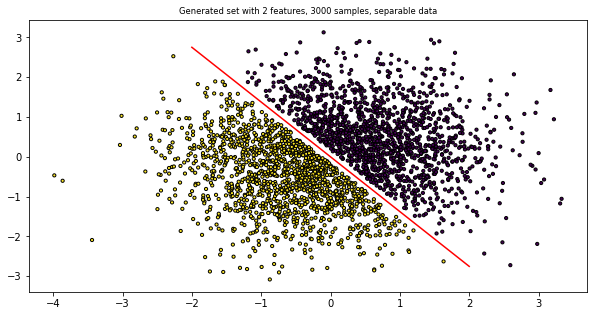

In [42]:
plt.figure(figsize=(10, 5))
plt.title("Generated set with 2 features, 3000 samples, separable data", fontsize="small")
x_3000, y_3000, v_normal = make_classification_normal(2, 3000, rho=0.1)
draw_data_by_coord01(x_3000, y_3000, v_normal)

In [44]:
REPEAT_COUNT = 5
TEST_SIZE = 1/3

clfs3000L, clfs3000J, rads3000, X_trains3000, y_trains3000, mgns3000L, mgns3000J, errs3000L, errs3000J = \
    params2classifiers_for_data(x_3000, y_3000, repeat_count = REPEAT_COUNT, test_size = TEST_SIZE)


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:29<00:00,  5.61s/it]


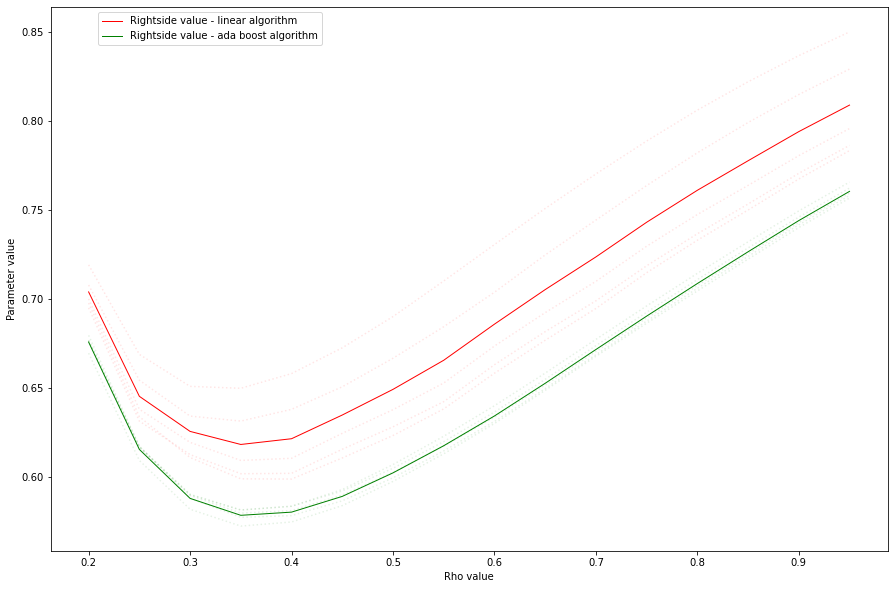

In [45]:
plt.figure(figsize=(15,10))
rho_vars = np.arange(0.2, 1, 0.05)
draw2classifiers_error_bound(X_trains3000, y_trains3000, clfs3000L, clfs3000J, rads3000, rho_vars)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:44<00:00,  5.24s/it]


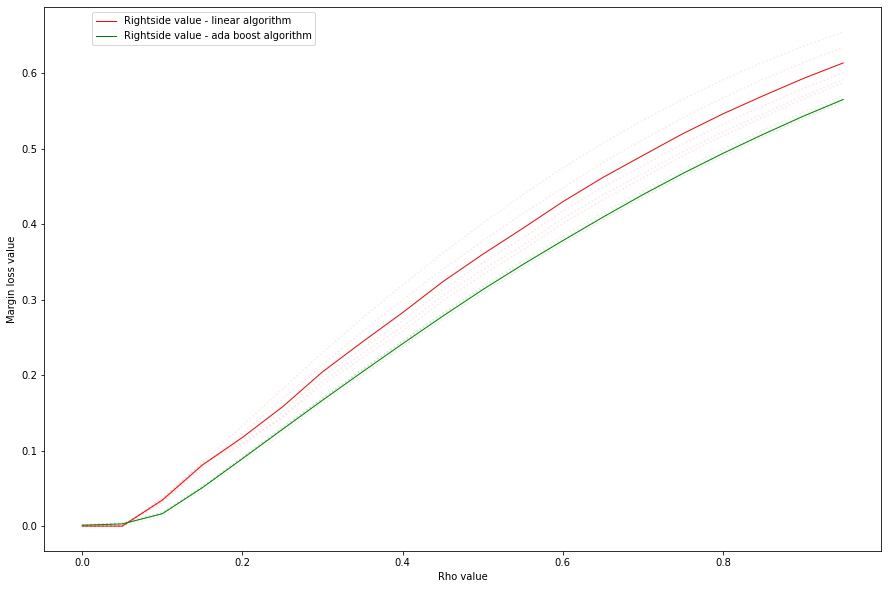

In [46]:
plt.figure(figsize=(15,10))
rho_vars = np.arange(0.0, 1, 0.05)
draw2classifiers_margin_loss(X_trains3000, y_trains3000, clfs3000L, clfs3000J, rho_vars)

In [48]:
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(REPEAT_COUNT))
print("Emperical error for linear algorithm: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(errs3000L), np.std(errs3000L)))
print("Emperical error for ada boost algorithm: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(errs3000J), np.std(errs3000J)))
print("Geometric margin for linear algorithm: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(mgns3000L), np.std(mgns3000L)))
print("Geometric margin for ada boost algorithm: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(mgns3000J), np.std(mgns3000J)))
print("Rademacher emperical complexity calculated: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(rads3000), np.std(rads3000)))

IN A SERIES OF TESTS OF 5 EXPERIMENTS:
Emperical error for linear algorithm: average-0.0040000000, std. deviation-0.0014142136
Emperical error for ada boost algorithm: average-0.0038000000, std. deviation-0.0011661904
Geometric margin for linear algorithm: average-0.0712518774, std. deviation-0.0073752974
Geometric margin for ada boost algorithm: average-0.0247974440, std. deviation-0.0108975323
Rademacher emperical complexity calculated: average-0.0495357800, std. deviation-0.0001788963


### 2. Separable normaly distributed data, 2 features, 10000 samples

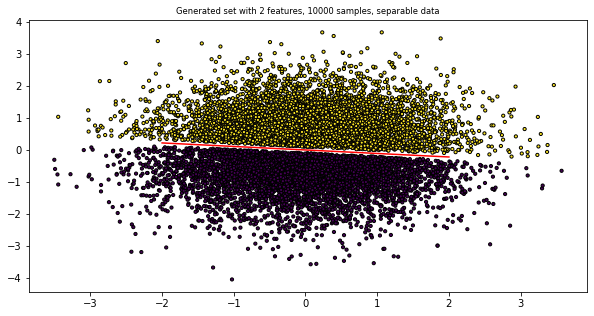

In [52]:
plt.figure(figsize=(10, 5))
plt.title("Generated set with 2 features, 10000 samples, separable data", fontsize="small")
x_10000, y_10000, v_normal = make_classification_normal(2, 10000, rho=0.1)
draw_data_by_coord01(x_10000, y_10000, v_normal)

In [ ]:
REPEAT_COUNT = 5
TEST_SIZE = 1/3

clfs10000L, clfs10000J, rads10000, X_trains10000, y_trains10000, mgns10000L, mgns10000J, errs10000L, err10000J = \
    params2classifiers_for_data(x_10000, y_10000, repeat_count = REPEAT_COUNT, test_size = TEST_SIZE)


In [ ]:
plt.figure(figsize=(15,10))
rho_vars = np.arange(0.05, 1, 0.05)
draw2classifiers_error_bound(X_trains10000, y_trains10000, clfs10000L, clfs10000J, rads10000, rho_vars)

In [ ]:
plt.figure(figsize=(15,10))
rho_vars = np.arange(0.0, 1, 0.05)
draw2classifiers_margin_loss(X_trains10000, y_trains10000, clfs10000L, clfs10000J, rho_vars)